In [166]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Machine Learning Engineering Nanodegree
## Project: Onde devo gastar o meu dinheiro?

## Criando base de dados

O objetivo é criar uma tabela contendo dados do crescimento do IFDM de 2012 em relação a 2011, população das cidades e gastos das cidades em cada uma das subáreas. A tabela objetivo está rotulada como gastos_ifdm_dif.

In [167]:
# Importando bases de dados

import numpy as np
import pandas as pd
from IPython.display import display

# Gastos por funcao no ano de 2012
gastos_2012 = pd.read_csv("Data/Despesas por funcao/despesaFuncao2012.csv", encoding="utf-8")

# Codigos de identificacao dos estados e municipios
codigo_municipio = pd.read_csv("Data/Codigo municipal/CodMun2012.csv", encoding='utf-8')
codigo_estado = pd.read_csv("Data/Codigo UF/CodUF2012.csv", encoding='utf-8')

# IFDM por categoria de 2005 a 2013
ifdm_geral_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_geral_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_saude_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_saude_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_empregoRenda_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_empregoRenda_2005-2013.csv", encoding="utf_8", sep=";")
ifdm_educacao_ano_base_2005_2013 = pd.read_csv("Data/IFDM/IFDM_educacao_2005-2013.csv", encoding="utf_8", sep=";")

# Metricas municipais em 2010 (IDH)
municipios_metricas = pd.read_csv("Data/Municipios/municipios.csv", encoding="utf-8", sep=";", decimal=",")

In [168]:
# Criando uma tabela para consulta de cidade e estado
estado_municipio = pd.merge(codigo_municipio, codigo_estado, how='inner', left_on=["CD_UF"], right_on=["CD_UF"])

In [169]:
# Filtra apenas os municipios com metricas mais recentes e busca apenas as colunas de interesse
municipio_populacao = municipios_metricas.loc[municipios_metricas['ANO'] == municipios_metricas['ANO'].max(), ['Municipio','UF','POP']]

# Trocando codigo de estado pelo nome do estado em municipio_ 
municipio_populacao = codigo_estado.merge(municipio_populacao, left_on=["CD_UF"], right_on=["UF"])
municipio_populacao.drop(['CD_UF', 'UF_y', 'ESTADO'], axis = 1, inplace = True)
municipio_populacao.rename(columns={'UF_x':'UF', 'POP':'Populacao'}, inplace=True)

display(municipio_populacao.head())

,UF,Municipio,Populacao
0,RO,ALTA FLORESTA D'OESTE,24097
1,RO,ARIQUEMES,89766
2,RO,CABIXI,6303
3,RO,CACOAL,78141
4,RO,CEREJEIRAS,16942


In [170]:
# Adicionando nome da cidade e estado à tabela de gastos_2012
gastos_2012_mun = gastos_2012.merge(estado_municipio, how='inner', left_on=["Cod Mun", "UF"], right_on=["CD_MUN", "CD_UF"])
gastos_2012_mun.drop(['CD_UF', 'CD_MUN', 'UF_x', 'Cod Mun', 'ESTADO'], axis = 1, inplace = True)
gastos_2012_mun.rename(columns={'UF_y':'UF', 'MUNICIPIO':'Municipio'}, inplace=True)

In [171]:
# Criando tabela de IFDM 
conditions = ['Codigo','Regiao','UF','Municipio']
ifdm = ifdm_geral_ano_base_2005_2013.merge(ifdm_saude_ano_base_2005_2013,on=conditions).merge(ifdm_empregoRenda_ano_base_2005_2013,on=conditions).merge(ifdm_educacao_ano_base_2005_2013,on=conditions)

# Removendo cidades sem algum valor de IFDM em algum ano
ifdm = ifdm.dropna()

# Calcula diferença do IFDM de 2012 e 2011
ifdm['ifdm_dif_saude'] = ifdm['2012_saude_nota'] - ifdm['2011_saude_nota']
ifdm['ifdm_dif_empregoRenda'] = ifdm['2012_empregoRenda_nota'] - ifdm['2011_empregoRenda_nota']
ifdm['ifdm_dif_educacao'] = ifdm['2012_educacao_nota'] - ifdm['2011_educacao_nota']
ifdm['ifdm_dif_geral'] = ifdm['2012_geral_nota'] - ifdm['2011_geral_nota']

# Filtra apenas colunas de interesse
ifdm_dif = ifdm[['Municipio','UF','Regiao','ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','ifdm_dif_geral','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota','2012_geral_nota']]

In [172]:
def remove_acentos(df, coluna):
    sem_acentos = df[coluna].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df.loc[:,coluna] = sem_acentos
    return df

# remove acentos dos nomes das cidades
gastos_2012_mun = remove_acentos(gastos_2012_mun, "Municipio")
ifdm_dif = remove_acentos(ifdm_dif, "Municipio")
municipio_populacao = remove_acentos(municipio_populacao, "Municipio")

In [173]:
def letras_minusculas(df, coluna):
    minusculas = df[coluna].str.lower()
    df.loc[:,coluna] = minusculas
    return df

# Coloca todas as cidades em letras minusculas
gastos_2012_mun = letras_minusculas(gastos_2012_mun, "Municipio")
ifdm_dif = letras_minusculas(ifdm_dif, "Municipio")
municipio_populacao = letras_minusculas(municipio_populacao, "Municipio")

In [174]:
# Adiciona ifdm_dif a tabela de gastos
## TODO: checar a diferenca de municipios esperada (algo perto de 5560 para a obtida de 4733)
gastos_ifdm_dif = ifdm_dif.merge(gastos_2012_mun, on=["Municipio","UF"])

# Renomeia algumas colunas
gastos_ifdm_dif.rename(columns={'Demais Subfuncoes 10':'Demais Subfuncoes Saude', 'Demais Subfuncoes 11':'Demais Subfuncoes Emprego','Demais Subfuncoes 12':'Demais Subfuncoes Educacao'}, inplace=True)

# Filtra features relacionadas a investimentos em trabalho, saude e educacao
gastos_ifdm_dif = gastos_ifdm_dif.loc[:,['ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','ifdm_dif_geral','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota','2012_geral_nota','Regiao','UF','Municipio','Saude','Atencao Basica','Assistencia Hospitalar','Suporte Profilatico','Vigilancia Sanitaria','Vigilancia Epidemiologica','Alimentacao e Nutricao','Demais Subfuncoes Saude','Trabalho','Protecao ao Trabalhador','Relacoes de Trabalho','Empregabilidade','Fomento ao Trabalho','Demais Subfuncoes Emprego','Educacao','Ensino Fundamental','Ensino Medio','Ensino Profissional','Ensino Superior','Educacao Infantil','Educacao de Jovens e Adultos','Educacao Especial','Demais Subfuncoes Educacao']]

In [175]:
# Adiciona populacao a tabela de gastos
gastos_ifdm_dif = gastos_ifdm_dif.merge(municipio_populacao, on=["Municipio","UF"])

display(gastos_ifdm_dif.head())

,ifdm_dif_saude,ifdm_dif_empregoRenda,ifdm_dif_educacao,ifdm_dif_geral,2012_saude_nota,2012_empregoRenda_nota,2012_educacao_nota,2012_geral_nota,Regiao,UF,...,Educacao,Ensino Fundamental,Ensino Medio,Ensino Profissional,Ensino Superior,Educacao Infantil,Educacao de Jovens e Adultos,Educacao Especial,Demais Subfuncoes Educacao,Populacao
0,0.0188,0.0071,-0.0499,-0.0080,0.5759,0.4499,0.6329,0.5529,Norte,RO,...,12582462.08,12047325.08,0.0,0.0,0.00,535137.00,0.00,0.00,0.00,24097
1,0.0096,-0.0136,0.0509,0.0156,0.8373,0.6393,0.7606,0.7457,Norte,RO,...,54395097.36,39715567.60,0.0,0.0,7334.65,3244596.33,509051.29,0.00,10918547.49,89766
2,0.0285,0.0091,0.0048,0.0141,0.6419,0.4650,0.7462,0.6177,Norte,RO,...,5149431.91,4808034.09,0.0,0.0,0.00,341397.82,0.00,0.00,0.00,6303
3,0.0376,0.0589,0.0128,0.0364,0.8258,0.7353,0.7169,0.7593,Norte,RO,...,28624919.59,19043958.99,0.0,0.0,0.00,6246226.28,0.00,80000.00,3254734.32,78141
4,-0.0265,0.2018,-0.0096,0.0553,0.5596,0.6370,0.7308,0.6425,Norte,RO,...,7100769.64,5854197.35,398673.2,0.0,0.00,813629.15,0.00,34269.94,0.00,16942


In [176]:
# Categoriza o tamanho das cidades pela populacao
gastos_ifdm_dif['Tamanho'] = np.where(gastos_ifdm_dif['Populacao'] < 50000, 'Pequena', 
        np.where(gastos_ifdm_dif['Populacao'] < 100000, 'Media-pequena',
                np.where(gastos_ifdm_dif['Populacao'] < 300000, 'Media',
                        np.where(gastos_ifdm_dif['Populacao'] < 500000, 'Media-grande',
                                np.where(gastos_ifdm_dif['Populacao'] < 1000000, 'Grande', 'Metropole')))))

# Análise descritiva


In [177]:
# Dados
display(gastos_ifdm_dif.head())

,ifdm_dif_saude,ifdm_dif_empregoRenda,ifdm_dif_educacao,ifdm_dif_geral,2012_saude_nota,2012_empregoRenda_nota,2012_educacao_nota,2012_geral_nota,Regiao,UF,...,Ensino Fundamental,Ensino Medio,Ensino Profissional,Ensino Superior,Educacao Infantil,Educacao de Jovens e Adultos,Educacao Especial,Demais Subfuncoes Educacao,Populacao,Tamanho
0,0.0188,0.0071,-0.0499,-0.0080,0.5759,0.4499,0.6329,0.5529,Norte,RO,...,12047325.08,0.0,0.0,0.00,535137.00,0.00,0.00,0.00,24097,Pequena
1,0.0096,-0.0136,0.0509,0.0156,0.8373,0.6393,0.7606,0.7457,Norte,RO,...,39715567.60,0.0,0.0,7334.65,3244596.33,509051.29,0.00,10918547.49,89766,Media-pequena
2,0.0285,0.0091,0.0048,0.0141,0.6419,0.4650,0.7462,0.6177,Norte,RO,...,4808034.09,0.0,0.0,0.00,341397.82,0.00,0.00,0.00,6303,Pequena
3,0.0376,0.0589,0.0128,0.0364,0.8258,0.7353,0.7169,0.7593,Norte,RO,...,19043958.99,0.0,0.0,0.00,6246226.28,0.00,80000.00,3254734.32,78141,Media-pequena
4,-0.0265,0.2018,-0.0096,0.0553,0.5596,0.6370,0.7308,0.6425,Norte,RO,...,5854197.35,398673.2,0.0,0.00,813629.15,0.00,34269.94,0.00,16942,Pequena


In [178]:
# Descricao dos dados pelo tamanho da cidade
g = gastos_ifdm_dif.groupby('Tamanho')

display(g.describe())

2012_educacao_nota  2012_empregoRenda_nota  \
Tamanho                                                           
Grande        count           23.000000               23.000000   
              mean             0.763557                0.743678   
              std              0.122712                0.057770   
              min              0.536900                0.610000   
              25%              0.652550                0.718100   
              50%              0.789400                0.765500   
              75%              0.866900                0.784650   
              max              0.929700                0.814800   
Media         count          186.000000              186.000000   
              mean             0.774097                0.712705   
              std              0.112689                0.103551   
              min              0.526500                0.408800   
              25%              0.686700                0.655650   
              50%              0.787350                0.742000   
              75%              0.864075                0.784500   
              max              0.974300                0.893300   
Media-grande  count           40.000000               40.000000   
              mean             0.772825                0.735743   
              std              0.113910                0.083223   
              min              0.594600                0.522600   
              25%              0.654000                0.703825   
              50%              0.778200                0.764950   
              75%              0.865550                0.796375   
              max              0.969800                0.845500   
Media-pequena count          301.000000              301.000000   
              mean             0.724968                0.622176   
              std              0.130989                0.135833   
              min              0.414400                0.225900   
              25%              0.628700                0.515200   
              50%              0.722800                0.616400   
              75%              0.832400                0.740400   
              max              0.982500                0.874700   
Metropole     count           14.000000               14.000000   
              mean             0.765429                0.767750   
              std              0.098218                0.026429   
              min              0.603100                0.725400   
              25%              0.693950                0.747875   
              50%              0.755250                0.766150   
              75%              0.836100                0.793950   
              max              0.906400                0.801700   
Pequena       count         3920.000000             3920.000000   
              mean             0.723732                0.482491   
              std              0.121651                0.121060   
              min              0.271400                0.121400   
              25%              0.637325                0.396000   
              50%              0.734100                0.466050   
              75%              0.811125                0.561750   
              max              1.000000                0.880300   

                     2012_geral_nota  2012_saude_nota  Alimentacao e Nutricao  \
Tamanho                                                                         
Grande        count        23.000000        23.000000            2.300000e+01   
              mean          0.781257         0.836570            1.149949e+05   
              std           0.069251         0.075541            3.918323e+05   
              min           0.656300         0.679500            0.000000e+00   
              25%           0.728100         0.795900            0.000000e+00   
              50%           0.801800         0.847800            0.000000e+00   
              75%     

In [201]:
# Utilizacao de cidades medias, media-grandes, grandes e metropoles no estudo
cidades_100_mais_hab = gastos_ifdm_dif.loc[gastos_ifdm_dif['Tamanho'].isin(['Metropole','Grande','Media-grande','Media'])]
n_cidades = len(cidades_100_mais_hab)
print "Numero de cidades na base: {}".format(n_cidades)

Numero de cidades na base: 263


In [202]:
print "Cidades por estado: "
print cidades_100_mais_hab['UF'].value_counts()

Cidades por estado: 
SP    73
RJ    23
MG    23
RS    18
PR    17
BA    15
SC    12
PE    12
ES     9
CE     8
GO     8
PA     7
MA     7
PB     4
MT     4
MS     4
RN     3
AL     2
AP     2
SE     2
RO     2
PI     2
TO     2
AM     2
RR     1
AC     1
Name: UF, dtype: int64


In [203]:
print "Cidades por regiao: "
print cidades_100_mais_hab['Regiao'].value_counts()

display(cidades_100_mais_hab.head())

Cidades por regiao: 
Sudeste         128
Nordeste         55
Sul              47
Norte            17
Centro-Oeste     16
Name: Regiao, dtype: int64


,ifdm_dif_saude,ifdm_dif_empregoRenda,ifdm_dif_educacao,ifdm_dif_geral,2012_saude_nota,2012_empregoRenda_nota,2012_educacao_nota,2012_geral_nota,Regiao,UF,...,Ensino Fundamental,Ensino Medio,Ensino Profissional,Ensino Superior,Educacao Infantil,Educacao de Jovens e Adultos,Educacao Especial,Demais Subfuncoes Educacao,Populacao,Tamanho
11,0.0339,-0.0035,0.0082,0.0128,0.6752,0.7418,0.6866,0.7012,Norte,RO,...,2.826770e+07,0.00,0.0,169120.88,1.868518e+06,0.00,85372.96,492485.95,115896,Media
16,0.0264,-0.1000,0.0152,-0.0195,0.7503,0.7279,0.6591,0.7124,Norte,RO,...,1.678237e+08,0.00,0.0,0.00,1.966643e+07,2603454.33,123325.93,30874280.03,422555,Media-grande
59,0.0232,-0.0261,0.0198,0.0056,0.7610,0.7639,0.7208,0.7485,Norte,AC,...,8.736560e+07,0.00,0.0,0.00,5.967091e+06,0.00,0.00,0.00,333052,Media-grande
82,-0.0082,-0.0381,0.0076,-0.0130,0.6791,0.7484,0.6490,0.6921,Norte,AM,...,6.349626e+08,0.00,0.0,8076813.87,1.011716e+08,11738741.04,2030878.90,29807449.16,1793443,Metropole
87,0.0373,-0.0220,0.0003,0.0052,0.6874,0.4929,0.7602,0.6468,Norte,AM,...,5.169426e+07,93784.29,0.0,36429.33,7.689319e+06,0.00,0.00,1913445.17,101218,Media


In [204]:
# Separa so os gastos de cada cidade

gastos = cidades_100_mais_hab
gastos.drop(['ifdm_dif_saude','ifdm_dif_empregoRenda','ifdm_dif_educacao','ifdm_dif_geral','2012_saude_nota','2012_empregoRenda_nota','2012_educacao_nota','2012_geral_nota','Regiao','UF','Municipio','Tamanho','Populacao'], axis = 1, inplace = True)

/home/allan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


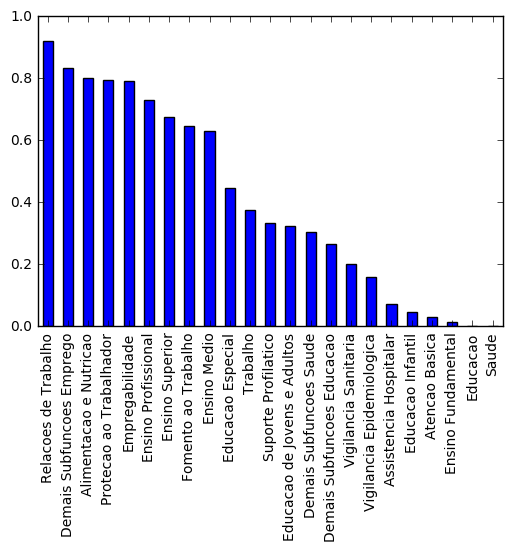

In [206]:
# Print ocorrencias de zeros
%matplotlib inline

total_ocorrencias = gastos[gastos == 0].count()
porcentagem_ocorrencias = total_ocorrencias/n_cidades
porcentagem_ocorrencias = porcentagem_ocorrencias.sort_values(ascending=False)

porcentagem_ocorrencias.plot.bar()

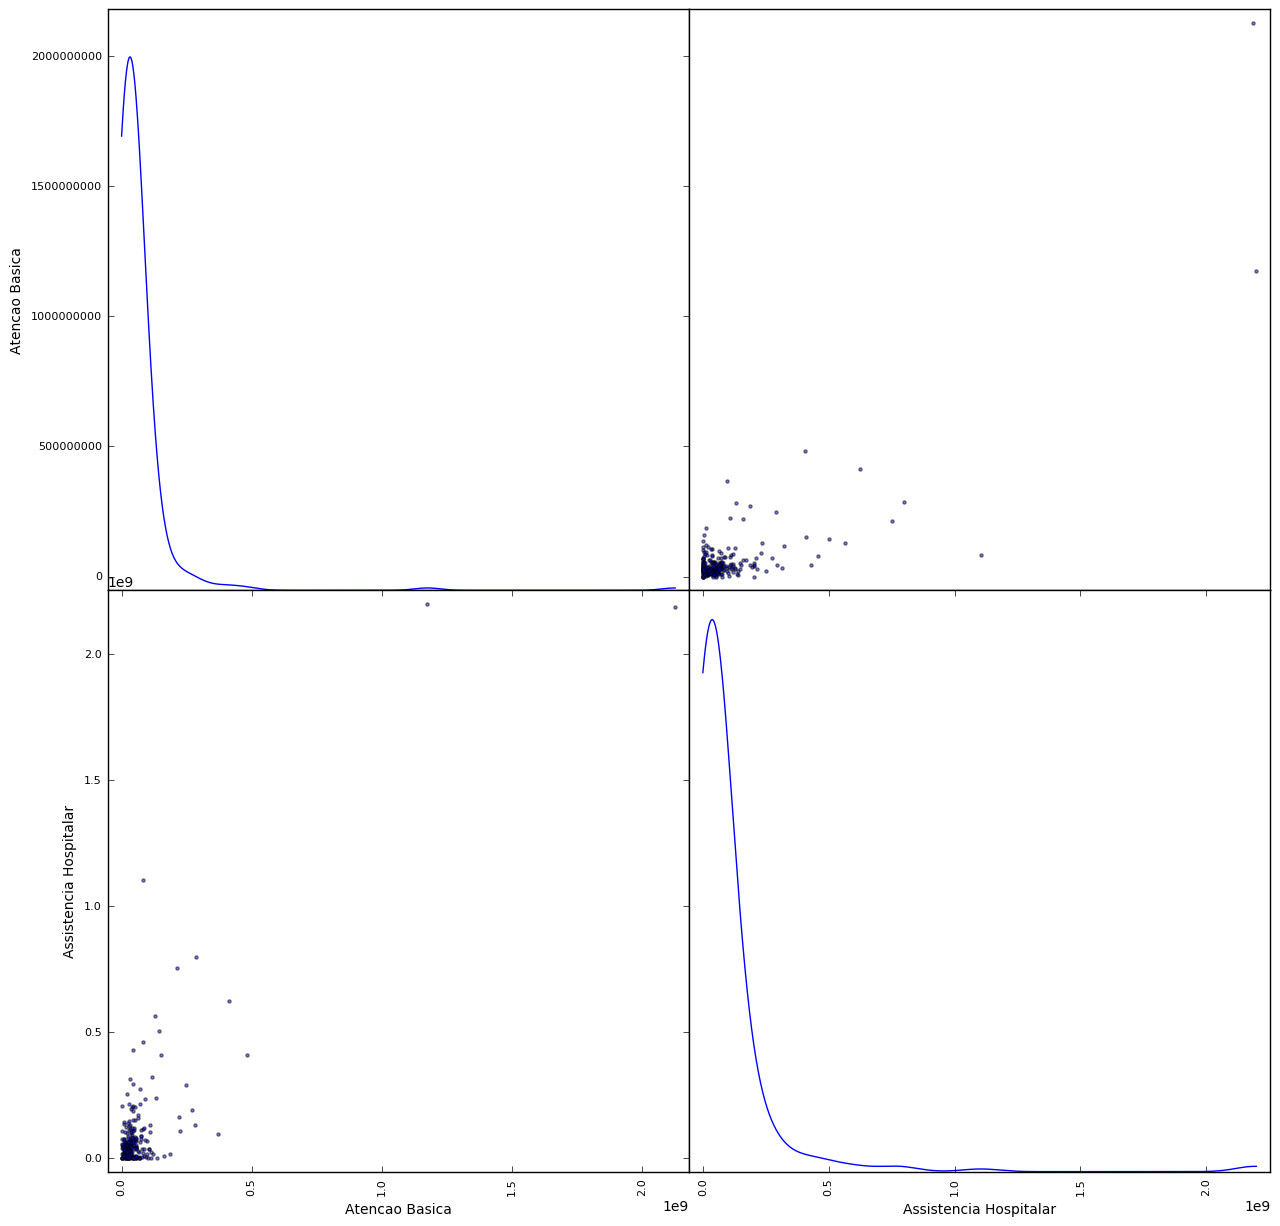

In [213]:
#%matplotlib inline
from pandas.tools.plotting import scatter_matrix

# Produz um scatterplot para cada par de features
scatter_matrix(gastos.iloc[:,1:3], figsize=(15, 15), diagonal='kde');

ValueError: array must not contain infs or NaNs

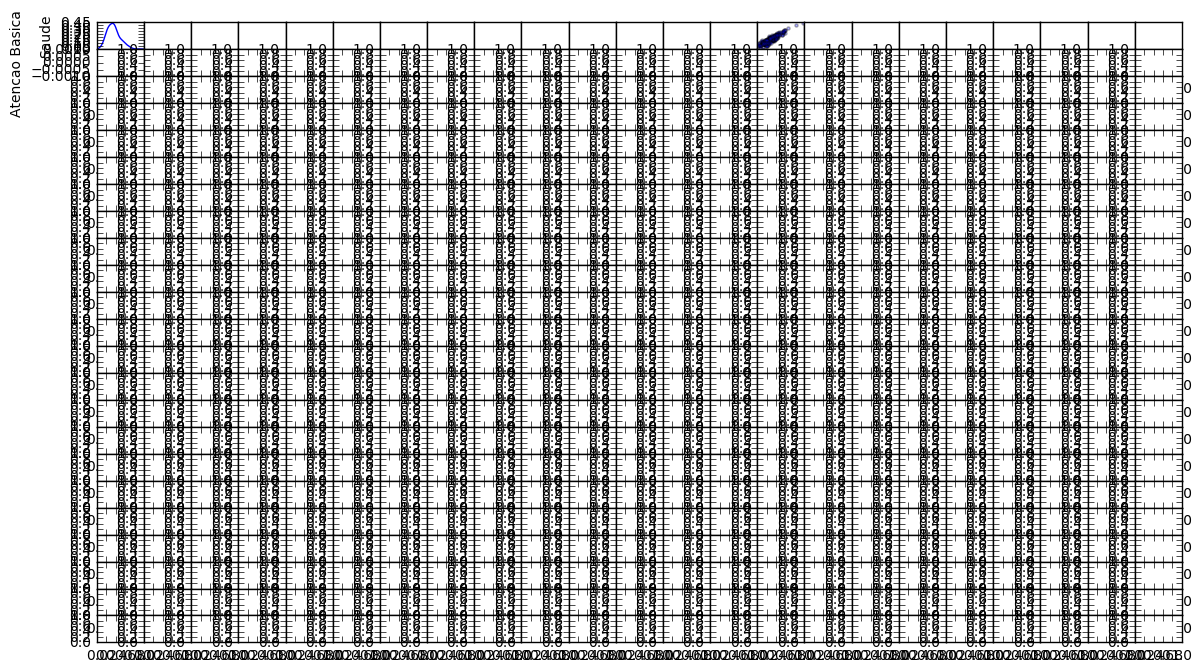

In [208]:
log_gastos = np.log(gastos)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_gastos, figsize = (14,8), diagonal = 'kde');

In [67]:
# retirando outliers

# Inicianilizando vetor vazio de outliers
#def remove_outliers(data):
data = cidades
    
outliers = np.empty(0, dtype=int)
for feature in data.keys():
    
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    
    step = np.multiply(1.5, Q3-Q1)
    
    # Mostra os outliers
    out = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
    #display(out)
    
    # Select the indices for data points you wish to remove
    outliers = np.append(outliers, out.index.values)

print outliers 
    # Remove os outliers
#good_data = data.drop(data.index[outliers]).reset_index(drop = True)
#    return good_data

#remove_outliers(cidades.iloc[:,11:14])

[  82  112  401  558  623  977 1194 1280 1662 1772 2347 2355 2366 2395 2477
 2518 2617 2780 2876 2920 2927 2929 2942 2947 2963 3106 3935 4085 4348   82
  112  558  623  820 1194 1280 1662 1772 1775 2355 2366 2376 2395 2518 2617
 2920 2927 2929 2947 3106 3935 4085 4348  112  148  558  623  820 1194 1280
 1325 1662 1772 1863 2334 2366 2395 2477 2518 2617 2780 2876 2920 2927 2929
 2930 2947 3106 3480 3935 4085 4348]


# Agrupamentos por gastos

## Maiores cidades do Brasil

## Maiores cidades por região

## Maiores cidades por UF